In [1]:
import json

In [2]:
from adamapi import Auth

a = Auth()
a.setKey("uYbFQUNw-1Gfgd3DPGvDKTiZ1ZBg1H7fBnG7j86UA38")
a.setAdamCore("https://explorer-space.adamplatform.eu/")
a.authorize()

{'expires_at': '2021-06-07T07:44:16.156Z',
 'access_token': 'f42335c2125b4069acef329ee8fa884d',
 'refresh_token': 'b8c89f7363094ffc9c7164658ba325a1',
 'expires_in': 3600}

In [3]:
from adamapi import Datasets

datasets = Datasets(a)
items = datasets.getDatasets()

print(json.dumps(items, indent=2))

{
  "type": "FeatureCollection",
  "properties": {
    "totalResults": 1,
    "itemsPerPage": 1,
    "maxRecords": 10,
    "page": 0
  },
  "content": [
    {
      "datasetId": "58592:MRO_CTX",
      "title": "Mars Reconnaissance Orbiter - Context Camera",
      "description": "Products from Context Camera instrument in Mars Reconnaissance Orbiter",
      "startDate": "2006-03-24T04:41:07Z",
      "endDate": "2012-02-28T19:37:15Z"
    }
  ]
}


In [4]:
ctx_dataset = datasets.getDatasets( '58592:MRO_CTX' )

print(f"Number of images: {ctx_dataset['numberOfRecords']}")

Number of images: 6495


In [5]:
from adamapi import Search

datasetId = '58592:MRO_CTX'

search = Search(a)

search_result = search.getProducts(
    datasetId,
    geometry={"type":"Polygon","coordinates":[[[-101,14],[-98,14],[-98,21],[-101,21],[-101,14]]]},
    startIndex=0,
    maxRecords=10)

print("Number of products found:", len(search_result['content']))

Number of products found: 10


In [6]:
for product in search_result['content']:
    print(product['productId'])
    print(product['productDate'])
    print(product['geometry'])

N09_065886_1967_XN_16N100W.tif
2020-08-16T08:09:24Z
{'geometries': [{'type': 'Polygon', 'coordinates': [[[-101.0093533, 15.2084285], [-100.1798775, 15.2084285], [-100.1682522, 17.919366], [-101.0094859, 17.919366], [-101.0093533, 15.2084285]]]}], 'type': 'GeometryCollection'}
K17_059820_1980_XI_18N100W.tif
2019-05-01T16:10:50Z
{'geometries': [{'type': 'Polygon', 'coordinates': [[[-100.7433223, 15.464693], [-99.6421235, 15.464693], [-99.6321884, 20.3210653], [-100.763958, 20.3210653], [-100.7433223, 15.464693]]]}], 'type': 'GeometryCollection'}
K15_059042_1994_XN_19N100W.tif
2019-03-02T01:13:59Z
{'geometries': [{'type': 'Polygon', 'coordinates': [[[-100.5004727, 18.6719131], [-99.8770188, 18.6719131], [-99.876209, 19.750957], [-100.503768, 19.750957], [-100.5004727, 18.6719131]]]}], 'type': 'GeometryCollection'}
K14_058831_1974_XN_17N099W.tif
2019-02-13T14:35:39Z
{'geometries': [{'type': 'Polygon', 'coordinates': [[[-100.4552914, 14.6824874], [-99.189035, 14.6824874], [-99.1654745, 19.9

In [7]:
import geopandas
from shapely.geometry import shape

_gd = {'productId':[], 'geometry':[]}
for p in search_result['content']:
    _gd['productId'].append(p['productId'])
    _gd['geometry'].append(shape(p['geometry']['geometries'][0]))
    
gdf = geopandas.GeoDataFrame(_gd)
gdf

,productId,geometry
0,N09_065886_1967_XN_16N100W.tif,"POLYGON ((-101.00935 15.20843, -100.17988 15.2..."
1,K17_059820_1980_XI_18N100W.tif,"POLYGON ((-100.74332 15.46469, -99.64212 15.46..."
2,K15_059042_1994_XN_19N100W.tif,"POLYGON ((-100.50047 18.67191, -99.87702 18.67..."
3,K14_058831_1974_XN_17N099W.tif,"POLYGON ((-100.45529 14.68249, -99.18904 14.68..."
4,K13_058541_1975_XN_17N099W.tif,"POLYGON ((-100.34533 14.69271, -99.24498 14.69..."
5,K13_058330_1994_XN_19N100W.tif,"POLYGON ((-100.44072 18.62262, -99.78690 18.62..."
6,K12_058040_1995_XN_19N100W.tif,"POLYGON ((-100.42723 18.65066, -99.79509 18.65..."
7,J17_051288_1999_XN_19N101W.tif,"POLYGON ((-101.71233 17.17529, -100.82598 17.1..."
8,J15_050721_2000_XN_20N101W.tif,"POLYGON ((-101.49850 17.18161, -100.47201 17.1..."
9,J03_045961_1964_XN_16N101W.tif,"POLYGON ((-101.25259 15.82016, -100.67999 15.8..."


<AxesSubplot:>

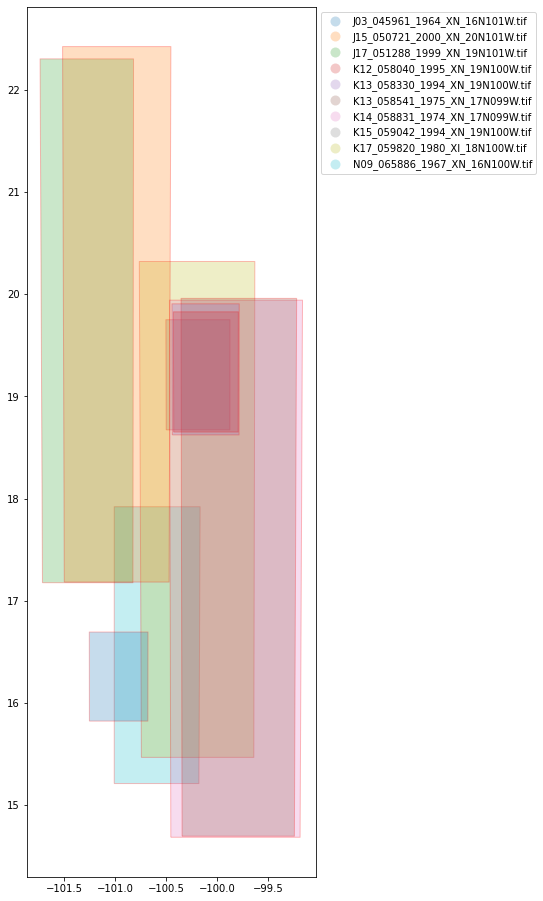

In [8]:
%matplotlib inline

gdf.plot(alpha=0.25, edgecolor='red', legend=True, column='productId', legend_kwds={'loc': 'upper left', 'bbox_to_anchor': (1, 1)}, 
         figsize=(24,16))

In [9]:
products = [
    'K13_058541_1975_XN_17N099W.tif',
    'K17_059820_1980_XI_18N100W.tif'
]

In [10]:
import shutil
from pathlib import Path

datapath = Path('data')
outpath = datapath / 'adamapiresults'

zips = []
for product in products:
    _tif = outpath / product
    _zip = _tif.with_suffix('.zip')
    if _zip.exists():
        print(f"Product '{product}' already downloaded")
        zips.append(_zip)
        continue
    print(f"Requesting '{product}'")
    _out = adam.GetData(a).getData(datasetId, productId=product, outputFname=_zip.as_posix())
    assert _out == _zip.as_posix()
    zips.append(_zip)

tiffs = []
for _zip in zips:
    _tif = _zip.with_suffix('.tif')
    shutil.unpack_archive(_zip, 'adamapiresults')
    tiffs.append(_tif)
    
tiffs

Product 'K13_058541_1975_XN_17N099W.tif' already downloaded
Product 'K17_059820_1980_XI_18N100W.tif' already downloaded


[PosixPath('data/adamapiresults/K13_058541_1975_XN_17N099W.tif'),
 PosixPath('data/adamapiresults/K17_059820_1980_XI_18N100W.tif')]

In [11]:
def rescale(filename_in, filename_out, factor=0.5):
    """
    Return filename of resampled image.
    """
    import rasterio
    from rasterio.enums import Resampling
    
    with rasterio.open(filename_in) as src:

        height = int(src.height * factor)
        width = int(src.width * factor)
        transform = src.transform * src.transform.scale(
                    (src.width / width),
                    (src.height / height)
        )

        # resample data to target shape
        data = src.read(
            out_shape=(src.count, height, width),
            resampling=Resampling.bilinear
        )
        data[data<=src.nodata] = src.nodata

        # copy src metadata, update as necessary for 'dst'
        kwargs = src.meta.copy()
        kwargs.update({
            'transform': transform,
            'width': width,
            'height': height
        })

        # reproject "src" to "dst"
        with rasterio.open(filename_out, 'w', **kwargs) as dst:
            for i, band in enumerate(data, 1):
                dst.write(band, i)

        return filename_out

In [12]:
resampled_tiffs = []
for _tif in tiffs:
    print(f"Resampling huge image: {_tif}..")
    _res = _tif.with_suffix('.resampled.tif')
    _out = rescale(_tif, _res)
    assert _out == _res
    resampled_tiffs.append(_res)
print(f"Done.")

Resampling huge image: data/adamapiresults/K13_058541_1975_XN_17N099W.tif..
Resampling huge image: data/adamapiresults/K17_059820_1980_XI_18N100W.tif..
Done.


In [13]:
import rasterio
from rasterio.merge import merge

output = outpath / 'mosaic.tif'

with rasterio.open(resampled_tiffs[0]) as src:
    meta = src.meta.copy()

# The merge function returns a single array and the affine transform info
arr, out_trans = merge(resampled_tiffs[::-1])

meta.update({
    "driver": "GTiff",
    "height": arr.shape[1],
    "width": arr.shape[2],
    "transform": out_trans
})

# Write the mosaic raster to disk
with rasterio.open(output, "w", **meta) as dest:
    dest.write(arr)

print(f"Mosaic output '{output}' complete")

Mosaic output 'data/adamapiresults/mosaic.tif' complete


In [15]:
import numpy as np
with rasterio.open(output) as tif:
    img = tif.read(1)
    img[img<=tif.nodata] = np.nan

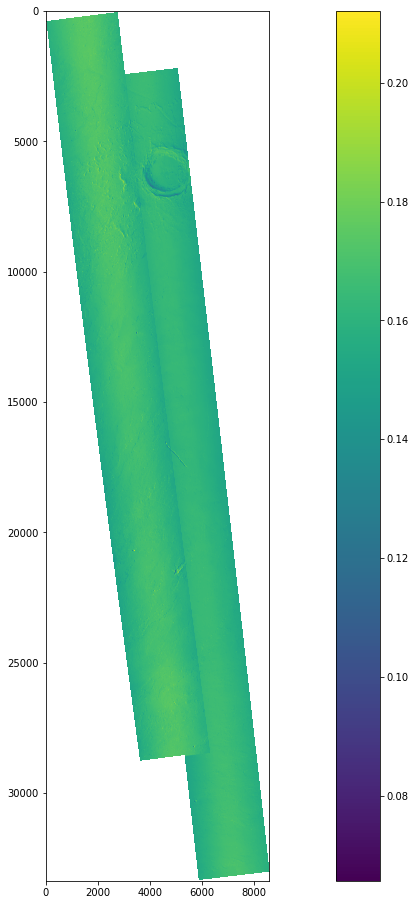

In [16]:
%matplotlib inline

from matplotlib import pyplot as plt

plt.subplots(figsize=(24,16))
plt.imshow(img, cmap = 'viridis')
plt.colorbar()